<a href="https://colab.research.google.com/github/josefigueroa168/ExplainableAI/blob/master/SGMM_Newborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Mixture Models for Population Health

This colab notebook accompanies the research paper by Xiao Shou et al. of the same name.

In [0]:
!pip install https://github.com/TheRensselaerIDEA/ExplainableAI/blob/master/dist/ExplainableAI-0.0.1-py3-none-any.whl?raw=true
!pip install -r https://raw.githubusercontent.com/TheRensselaerIDEA/ExplainableAI/master/requirements.txt

In [0]:
from explainableAI.models import SupervisedBMM, SupervisedGMM
from explainableAI.metrics import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster,sgmmResults
from explainableAI.models.mlModels import *
from explainableAI.metrics.utility import entropy,asymm_entropy
from explainableAI.metrics.ftest_logodds import ftest_uncorr, restest
from explainableAI.visual.clustmap import plotclustmap
#from explainableAI.visual import PDF
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import time

random.seed(300)

# SPARCS Data

[SPARCS](https://www.health.ny.gov/statistics/sparcs/) is a comprehensive all payer data reporting system established in 1979 as a result of cooperation between the healthcare industry and government. The system was initially created to collect information on discharges from hospitals. SPARCS currently collects patient level detail on patient characteristics, diagnoses and treatments, services, and charges for each hospital inpatient stay and outpatient (ambulatory surgery, emergency department, and outpatient services) visit; and each ambulatory surgery and outpatient services visit to a hospital extension clinic and diagnostic and treatment center licensed to provide ambulatory surgery services.


# Data Preparation

In [3]:
# Import/View Dataset

sparcs_df = pd.read_csv("https://github.com/TheRensselaerIDEA/ExplainableAI/blob/master/Data/sparcs25%25Newborn_DeHos_Outflow_Region.csv?raw=true")
sparcs_df.head()

,New_York_City,Hudson_Valley,Long_Island,Capital_Adiron,Central_NY,Southern_Tier,Western_NY,Finger_Lakes,Albany,Allegany,Bronx,Broome,Cattaraugus,Cayuga,Chautauqua,Chemung,Chenango,Clinton,Columbia,Cortland,Dutchess,Erie,Franklin,Fulton,Genesee,Jefferson,Kings,Lewis,Livingston,Madison,Manhattan,Monroe,Montgomery,Nassau,Niagara,Oneida,Onondaga,Ontario,Orange,Oswego,...,CCS_PROC_OT_OR_THER_PRC_ON_JOINT,CCS_PROC_OT_OR_THER_PRC_SKN_BRST,CCS_PROC_OT_OR_THER_PRC__FEM_ORG,CCS_PROC_OT_OR_THER_PRCS_ON_BONE,CCS_PROC_OT_OR_THER_PRCS_URINARY,CCS_PROC_OT_OR_THER_PRCS__MALE,CCS_PROC_OT_OR_UP_GI_THER_PRCS,CCS_PROC_OT_PHYS_THER_REHAB,CCS_PROC_OT_THER_PRCS_ON_MUSCLES,CCS_PROC_OT_THER_PRCS__HEM_LYMPH,CCS_PROC_OT_THERAPEUTIC_EAR_PRCS,CCS_PROC_OT_VASC_CATH__NOT_HEART,CCS_PROC_OT_VASCULAR_BYP_SHUNT,CCS_PROC_OTHER_BOWEL_DX_PRCS,CCS_PROC_OTHER_DX_NERV_SYS_PRCS,CCS_PROC_OTHER_DX_ULTRASOUND,CCS_PROC_OTHER_GI_DX_PRCS,CCS_PROC_OTHER_HERNIA_REPAIR,CCS_PROC_OTHER_OR_HEART_PRCS,CCS_PROC_OTHER_OR_THER_NERV_SYS,CCS_PROC_OTHER_OR_THER_PRCS_NOSE,CCS_PROC_OTHER_RESP_THERAPY,CCS_PROC_OTHER_THERAPEUTIC_PRCS,CCS_PROC_PHYS_THER_EXER_MANIPUL,CCS_PROC_PRCS_ON_THE_URETHRA,CCS_PROC_PROCTOSCOPY_and_AR_BIOPSY,CCS_PROC_PROPHYLACTIC_VAC_INOCUL,CCS_PROC_RESP_INTUB_MECH_VENTIL,CCS_PROC_ROUTINE_CHEST_X_RAY,CCS_PROC_SKIN_GRAFT,CCS_PROC_SMALL_BOWEL_RESECTON,CCS_PROC_SUTURE_SKIN_SUBCUT_TISS,CCS_PROC_SWAN_GANZ_CATH_MONITOR,CCS_PROC_TRACHE__LARYNG_OSCOPY,CCS_PROC_TRACHEOSTOMY__TEMP_PERM,CCS_PROC_TRACTN_SPLNT_OT_WOUND,CCS_PROC_TRTMNTFACE_FRACT_DISLC,CCS_PROC_TRTMNTFRAC_LOWR_EXTREM,CCS_PROC_UPPER_GI_X_RAY,Target
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Test/Train Split

d_newborn_tr, d_newborn_te = train_test_split(sparcs_df, test_size=0.2, random_state = 1512)
print("Train Shape: ", d_newborn_tr.shape)
print("Test Shape: ", d_newborn_te.shape)

Train Shape:  (93543, 260)
Test Shape:  (23386, 260)


In [0]:
#Preparing the data

Xtrain, Xtest = d_newborn_tr.values[:,0:-1], d_newborn_te.values[:,0:-1]
ytrain, ytest = d_newborn_tr.values[:,-1].astype(int), d_newborn_te.values[:,-1].astype(int)

In [0]:
# Metrics Columns
columns = ['cluster', 'size', 'high_cost%','low_cost%', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']

# Feature List
features = sparcs_df.columns[:-1]

In [7]:
# Split train into train/validation sets

train_df, val_df = train_test_split(d_newborn_tr, test_size = 0.2, random_state = 1512)
y_train_df, y_val_df = train_df.iloc[:,-1], val_df.iloc[:,-1]
print("Train Shape: ", train_df.shape)
print("Validation Shape: ", val_df.shape)

Train Shape:  (74834, 260)
Validation Shape:  (18709, 260)


# Pick k

Select 'k' based on AUC. The following cell runs our Supervised Bernoulli Mixture Model across cluster sizes 2-10 with 10 randomly generated seeds. 

**Warning:** The following 2 cells may take up to several hours. It is available for validaiton but not required for the rest of the notebook.

## SBMM

In [0]:
#SET SBMM/SGMM PARAMETERS

max_iter = 30
max_iter2 = 30

train_np = train_df.values[:,0:-1]
val_np = val_df.values[:,0:-1]

y_train_np = y_train_df.values
y_val_np = y_val_df.values

test_re_B = []
train_re_B = []
seed_list_B = []

start = time.time()

for j in range(0,10): 

    seed_num = random.randint(0,100000)
    seed_list_B.append(seed_num)
    print("\n TRAINING WITH RANDOM SEED {}". format(seed_num))

    #test clusters 2-10
    for i in range(2,10):
        print("\n\n\nTRAINING WITH {} CLUSTERS".format(i))
        np.random.seed( seed = seed_num)
        modelB = SupervisedBMM(max_iter = max_iter, max_iter2 = max_iter2, n_clusters = i)
        modelB = modelB.fitB(Xtrain = train_np, Xtest=val_np, ytrain = y_train_np)

        logisRegre = modelB.LogRegr
        fitP = modelB.fitParams
        labTrainB  = fitP['labTrain']
        mTest = modelB.predict_BMMS(val_np)
        labTestB = np.argmax( mTest, axis = 1 )

        probTest, probTrain = modelB.predict_prob_int_B( Xtest = val_np, Xtrain = train_np )
        tau = optimalTau(probTrain, y_train_np)
        metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = y_val_np)
        metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = y_train_np)
        metTestSBMM = pd.DataFrame( [metTest], columns = columns)
        metTrainSBMM = pd.DataFrame( [metTrain], columns = columns)

        test_re_B.append( metTestSBMM )
        train_re_B.append( metTrainSBMM )
end = time.time() - start
print("time elapsed: {}".format( end ))


#PICK THE CLUSTERS

pdi = pd.DataFrame(np.zeros(shape = [len(test_re_B), test_re_B[0].shape[1]]), columns = columns)
pdi_tr = pd.DataFrame(np.zeros(shape = [len(train_re_B), train_re_B[0].shape[1]]), columns = columns)

for i, panda in enumerate(test_re_B):
     pdi.iloc[i,:] = panda.iloc[0,:]
        
for i, panda in enumerate(train_re_B):
     pdi_tr.iloc[i,:] = panda.iloc[0,:]

pdi['seed_number'] = pd.DataFrame(np.repeat(np.array(seed_list_B),9) )
pdi['cluster']= pd.DataFrame(np.tile(np.arange(2,10),10))

print('Here are the number of clusters and seed_number for the largest auc ')
print(pdi.sort_values(by = 'auc',ascending=False).iloc [0,:][['cluster','auc','seed_number']])
print('Here are the number of clusters and seed_number for the smallest auc ')
print(pdi.sort_values(by = 'auc',ascending=True).iloc [0,:][['cluster','auc','seed_number']])

## SGMM

In [0]:
for j in range(0,10): 

    seed_num = random.randint(0,100000)
    seed_list.append(seed_num)
    print("\n TRAINING WITH RANDOM SEED {}". format(seed_num))
#test clusters 2-10
    for i in range(2,11):
        print("\n\n\nTRAINING WITH {} CLUSTERS".format(i))
        np.random.seed( seed = seed_num )
        model = SupervisedGMM(max_iter = max_iter, max_iter2 = max_iter2, n_clusters = i)
        model = model.fit(Xtrain = train_np, ytrain = y_train_np)
        probTrain = model.predict_proba( train_np )
        probTest = model.predict_proba( val_np )
        results = sgmmResults( model, probTest.copy(), probTrain.copy(), y_val_np.copy(), y_train_np.copy(), tau = None,
            mode = 0)
        testmetrics = results['testMet']
        trainMetrics = results[ 'trainMet']
        test_re.append( testmetrics )
        train_re.append( trainMetrics )
    
end = time.time() - start
print("time elapsed: {}".format( end ))

#PICK THE CLUSTERS

pdi = pd.DataFrame(np.zeros(shape = [len(test_re), test_re[0].shape[1]]), columns = columns)
pdi_tr = pd.DataFrame(np.zeros(shape = [len(train_re), train_re[0].shape[1]]), columns = columns)

for i, panda in enumerate(test_re):
     pdi.iloc[i,:] = panda.iloc[0,:]
        
for i, panda in enumerate(train_re):
     pdi_tr.iloc[i,:] = panda.iloc[0,:]

pdi['seed_number'] = pd.DataFrame(np.repeat(np.array(seed_list),9) )
pdi['cluster']= pd.DataFrame(np.tile(np.arange(2,11),10))


print('Here are the number of clusters and seed_number for the largest auc ')
print(pdi.sort_values(by = 'auc',ascending=False).iloc [0,:][['cluster','auc','seed_number']])
print('Here are the number of clusters and seed_number for the smallest auc ')
print(pdi.sort_values(by = 'auc',ascending=True).iloc [0,:][['cluster','auc','seed_number']])

print('BASED ON THAT WE PICK 7 CLUSTERS with seed = 21274')

# SBMM with 7 clusters

In [8]:
# Load pre-written model for SBMM
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download("https://github.com/TheRensselaerIDEA/ExplainableAI/blob/master/test_models/SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl?raw=true"
        ,"SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")
print("Download Complete")

Download file... SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl ...
File downloaded
Download Complete


In [9]:
np.random.seed( seed = 71730 )
pre_load = True

# train SBMM model with Log Regression
max_iter = 30
max_iter2 = 30
n_clusters = 7

if pre_load:
  modelB = SupervisedBMM.loader("SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")
  print("ModelB successfully loaded...")
else:
  modelB = SupervisedBMM( max_iter =max_iter, n_clusters = n_clusters, max_iter2 = max_iter2, verbose = 0, penalty="l2")
  modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain)

mTrain = modelB.mTrain
logisRegre = modelB.LogRegr
fitP = modelB.fitParams
labTrainB  = fitP['labTrain']
mTest = modelB.predict_BMMS(Xtest)
labTestB = np.argmax( mTest, axis = 1 )

probTest, probTrain = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSBMM = pd.DataFrame( [metTest], columns = columns)
metTrainSBMM = pd.DataFrame( [metTrain], columns = columns)

metTrainSBc, metTestSBc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestB,
                                        trainlabels = labTrainB,
                                        Xtrain = Xtrain, Xtest = Xtest)

ModelB successfully loaded...


In [0]:
# If you want to save current model
from google.colab import files
modelB.save("SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")
files.download("SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")

## Evaluation

### Cadrewise Train

In [10]:
metTrainSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]]

,size,high_cost%,f1,auc
0,15644.0,0.11,0.55,0.85
1,8143.0,0.20,0.52,0.80
2,6533.0,0.22,0.60,0.86
3,17744.0,0.23,0.58,0.84
4,16733.0,0.26,0.57,0.78
5,26322.0,0.34,0.57,0.73
6,2424.0,0.53,0.84,0.90


### Cadrewise Test

In [11]:
metTestSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]]

,size,high_cost%,f1,auc
0,3951.0,0.11,0.56,0.85
1,2088.0,0.20,0.52,0.79
2,1673.0,0.23,0.59,0.85
3,4309.0,0.23,0.57,0.83
4,4134.0,0.26,0.55,0.77
5,6675.0,0.33,0.55,0.72
6,556.0,0.51,0.81,0.89


### Cadre Cost vs Size Analysis

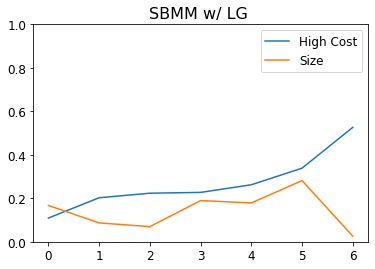

In [12]:
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y=sorted(metTrainSBc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y= metTrainSBc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SBMM w/ LG ',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)
plt.show()

# Cost Groups: SBMM

In [16]:
# Cadre average high cost share statistics
target = pd.DataFrame(np.array([ytrain, labTrainB]).T,columns=['Target', 'Cadre'])
target["Size"] = 1
aggr_target = target.groupby("Cadre").agg({"Size": "sum",  "Target": "mean"}).round(2)
print("Cadre average \"High Cost\" share statistics")
aggr_target

Cadre average "High Cost" share statistics


,Size,Target
Cadre,,
0,6533,0.22
1,15644,0.11
2,16733,0.26
3,2424,0.53
4,8143,0.20
5,17744,0.23
6,26322,0.34


In [18]:
print('Percent of high cost ratio by SBMM')
print(aggr_target.sort_values(by="Target", ascending=False))
print()

print('Relative cadre size by SBMM')
print((aggr_target["Size"]/aggr_target["Size"].sum()).round(3))
print()

print('Log odds ratio for each cadre by SBMM')
print(restest(np.expand_dims(labTrainB,axis=1),
        np.expand_dims(target['Target'],axis=1))[np.argsort(aggr_target["Target"].values)].round(2))

Percent of high cost ratio by SBMM
        Size  Target
Cadre               
3       2424    0.53
6      26322    0.34
2      16733    0.26
5      17744    0.23
0       6533    0.22
4       8143    0.20
1      15644    0.11

Relative cadre size by SBMM
Cadre
0    0.070
1    0.167
2    0.179
3    0.026
4    0.087
5    0.190
6    0.281
Name: Size, dtype: float64

Log odds ratio for each cadre by SBMM
[-1.15 -0.3  -0.16 -0.16  0.08  0.62  1.24]


# The log odds ratio of high cost in different clusters


In [0]:
# Order labels
sortedLabels = np.argsort(aggr_target["Target"].values).tolist()
Labels2 = np.zeros(labTrainB.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( labTrainB == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2

In [0]:
# Range or list of indicies
categories = {
    "Race": range(61,69),
    "Region": range(0,8),
    "Admission": range(75,80),
    "ER": range(70,72),
    "Disease1": range(80,113),
    "Disease2": range(113,142),
    "Procedure1": range(142,200),
    "Procedure2": range(200,259)
}

In [30]:
np_feat = np.asarray(features)
labs_binary = np.expand_dims(ytrain,axis=1)
feat_table_binary,lor_table_binary =ftest_uncorr(Xtrain,labs_binary,np_feat)
pd.DataFrame(lor_table_binary[:,categories["Race"]],columns = features[[categories["Race"]]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,Black_African_American,Multi_racial,Other_Race,White,Multi_Ethnic,Not_Span_Hispanic,Spanish_Hispanic,Unknown_Ethnicity
0,-0.144681,-0.594887,-0.325558,0.536927,-0.830452,-0.048132,-0.060539,0.329373
1,0.144681,0.594887,0.325558,-0.536927,0.830452,0.048132,0.060539,-0.329373


In [0]:
data = d_newborn_tr.iloc[:,:-1]
features = list(d_newborn_tr.iloc[:,:-1])
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

## Clean up feature text

In [0]:
# reduce feature length

new_feat = [s.replace('CCS_DX_' , '') for s in features]
new_feat = [s.replace('CCS_PROC_' , '') for s in new_feat]
new_feat = [s.replace('not_mental_disorders_or_infectious_disease','')for s in new_feat]
new_feat = [s.replace('birth weight; and','BW&')for s in new_feat]
new_feat = [s.replace('sexually_transmitted_disease','STD')for s in new_feat]
new_feat = [s.replace('tuberculosis','TB')for s in new_feat]
new_feat = [s.replace('system','syst')for s in new_feat]

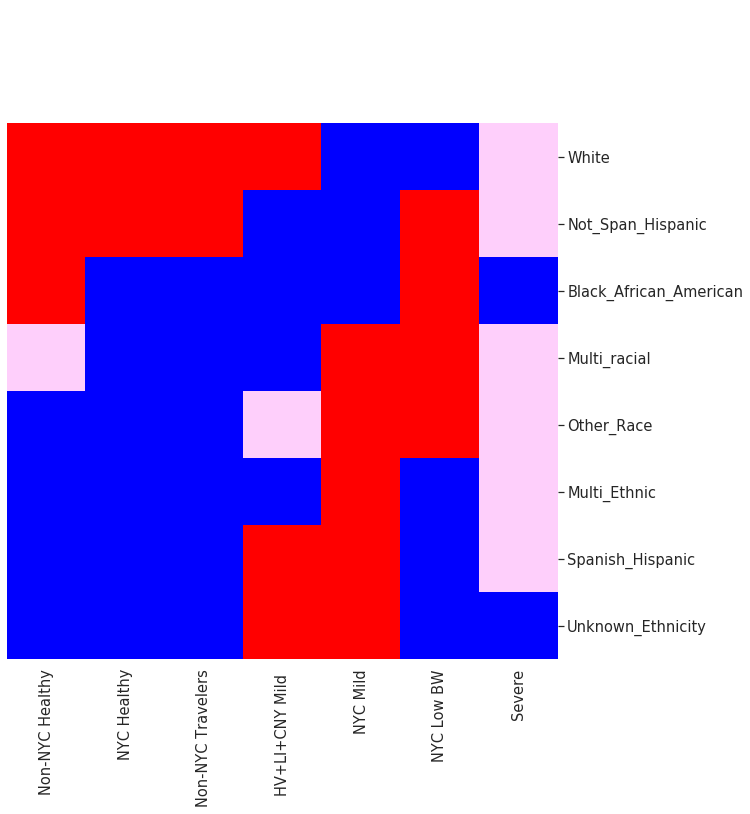

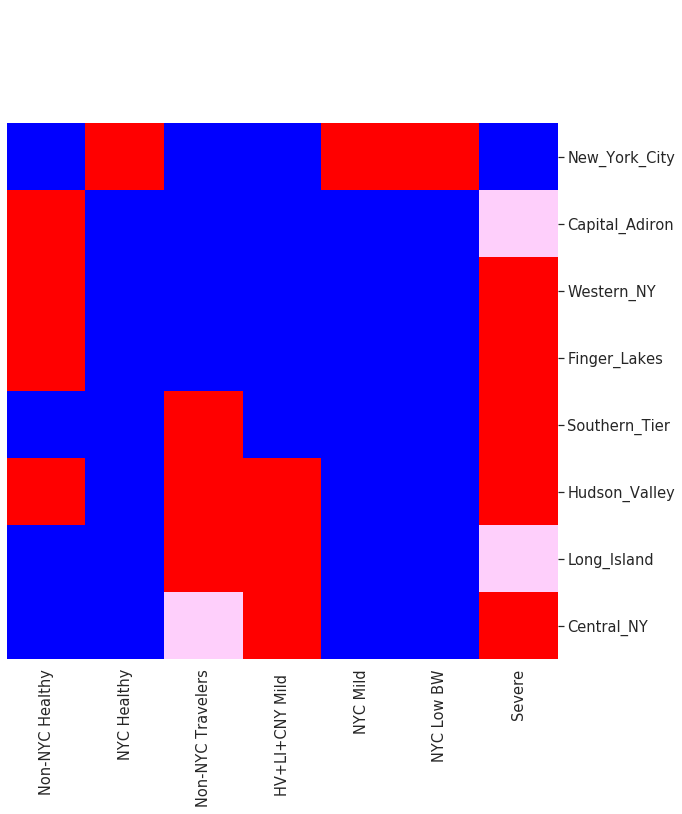

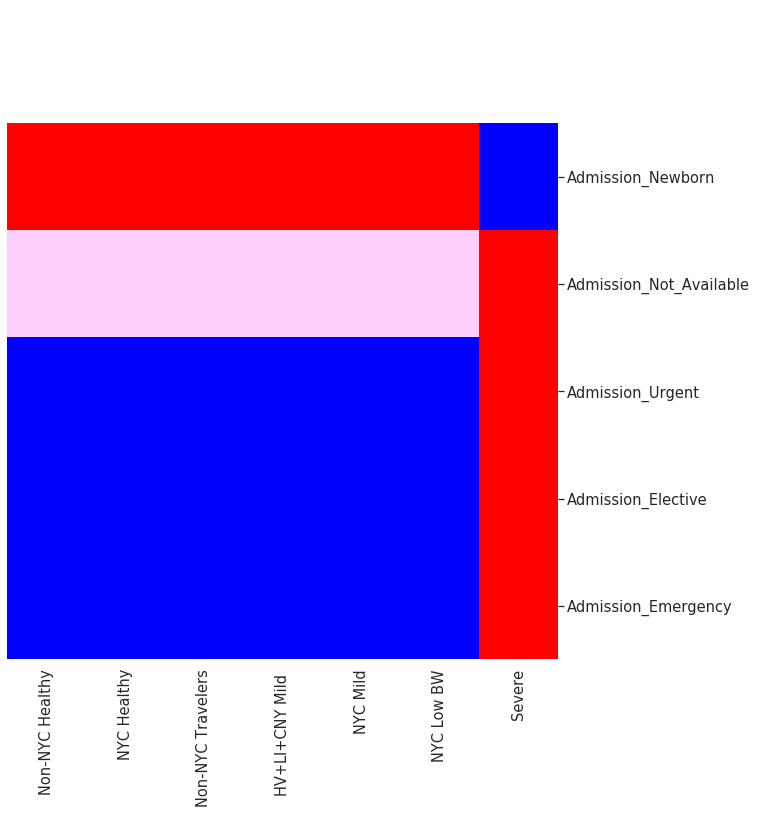

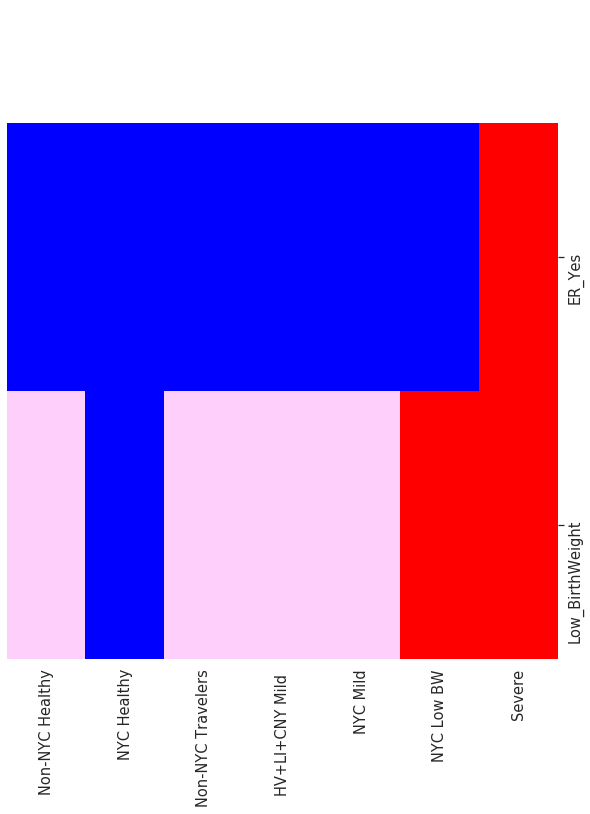

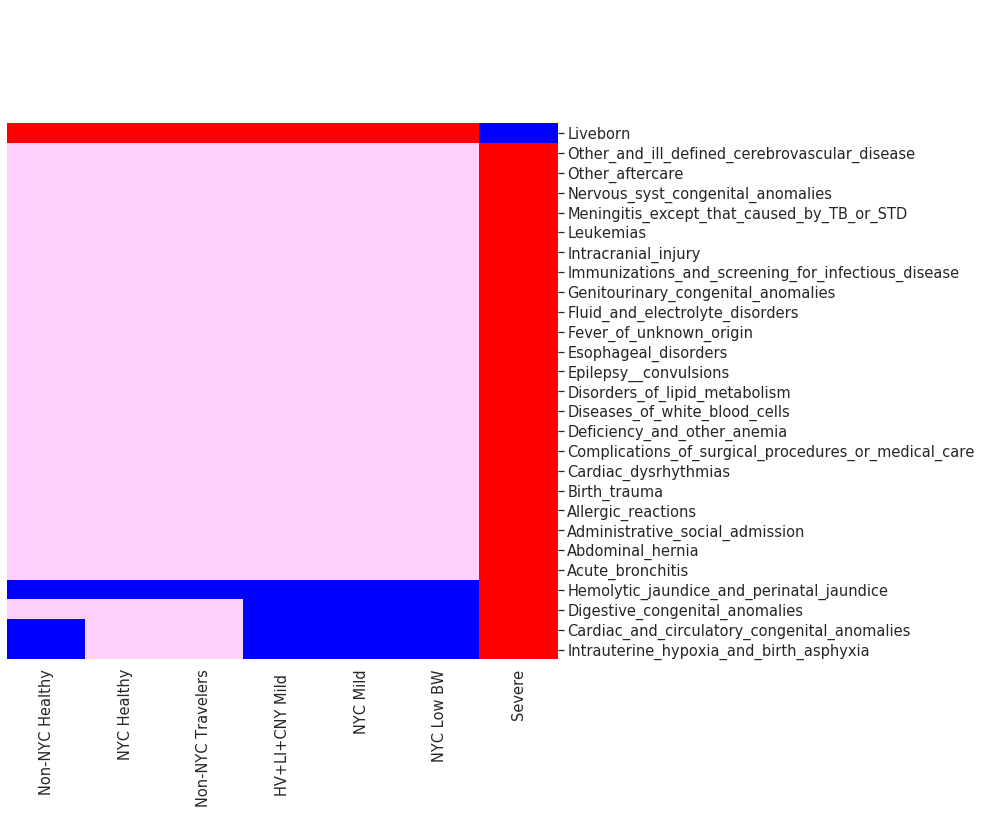

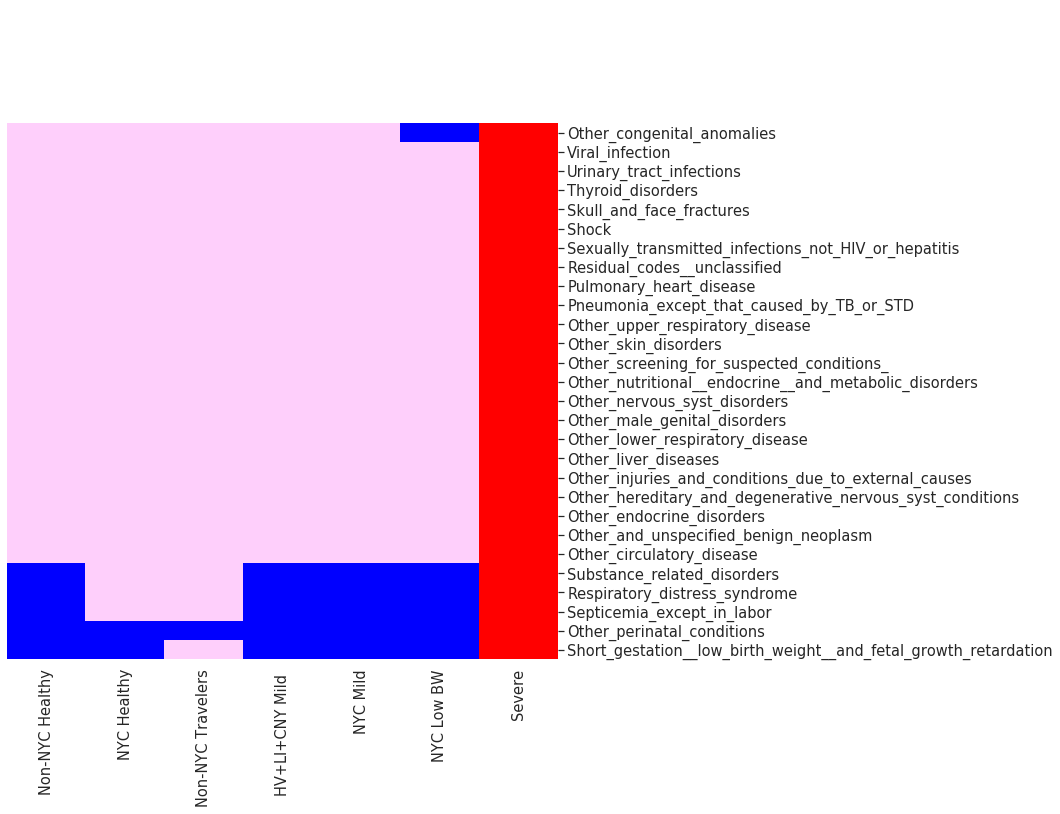

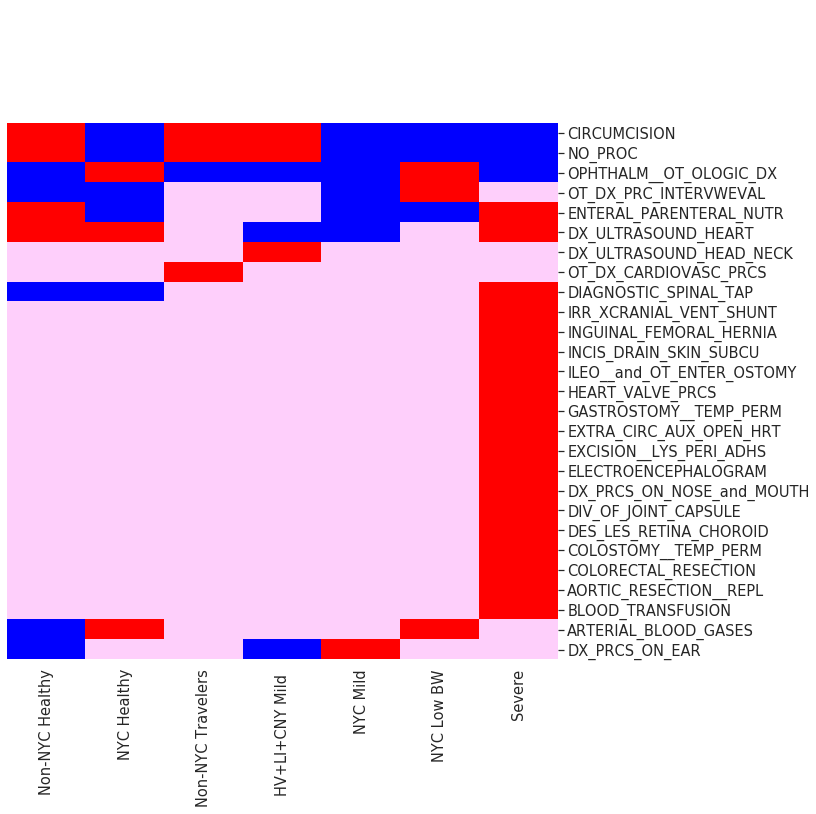

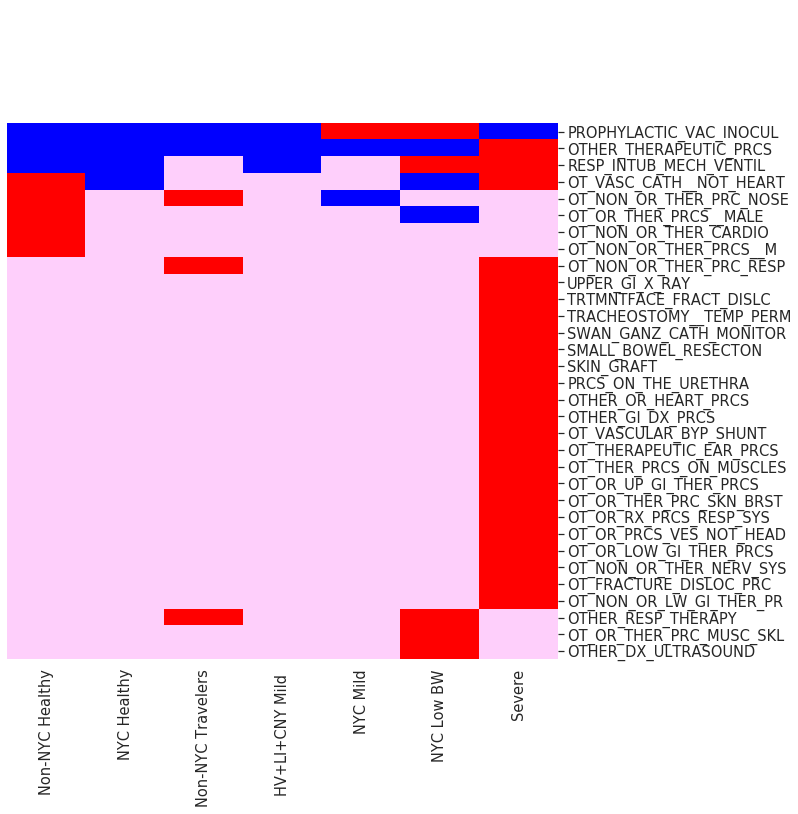

In [33]:
#Plot various categories
clustname = ['Non-NYC Healthy','NYC Healthy','Non-NYC Travelers','HV+LI+CNY Mild ','NYC Mild','NYC Low BW','Severe']

sns.set(font_scale=1.33)

for cat, val in categories.items():
  if cat in {"Disease1", "Disease2", "Procedure1", "Procedure2"}:
    filter = np.sum(abs(feat_table[:,val]),axis=0)>0
  else:
    filter = np.ones(shape=feat_table[:,val].shape[1]).astype(bool)
  plotclustmap(feat_table[:,val][:,filter].T,
             None,np.array(new_feat)[val][filter],None,None, clustname)

# Cadre Weights